In [ ]:
# Import Statements
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
import os
import torch
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import csv
import random
from transformers import AutoImageProcessor, ViTModel
import timm

# if you are running this code in Jupyter notebook
%matplotlib inline

In [ ]:
# Setting the seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Loading the Dataset:**

In [ ]:
# Reading the labels
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')

nums = list(range(1, len(df)))
random.shuffle(nums)

# Splitting the Training, Validation and Test set
train_df = df.loc[df.index.isin(nums[:int(len(df) * 0.7)])].reset_index().drop(columns = "index")
val_df = df.loc[df.index.isin(nums[int(len(df) * 0.7):int(len(df) * 0.9)])].reset_index().drop(columns = "index")
test_df = df.loc[df.index.isin(nums[int(len(df) * 0.9):int(len(df) * 1)])].reset_index().drop(columns = "index")

<AxesSubplot:title={'center':'Data Distribution'}>

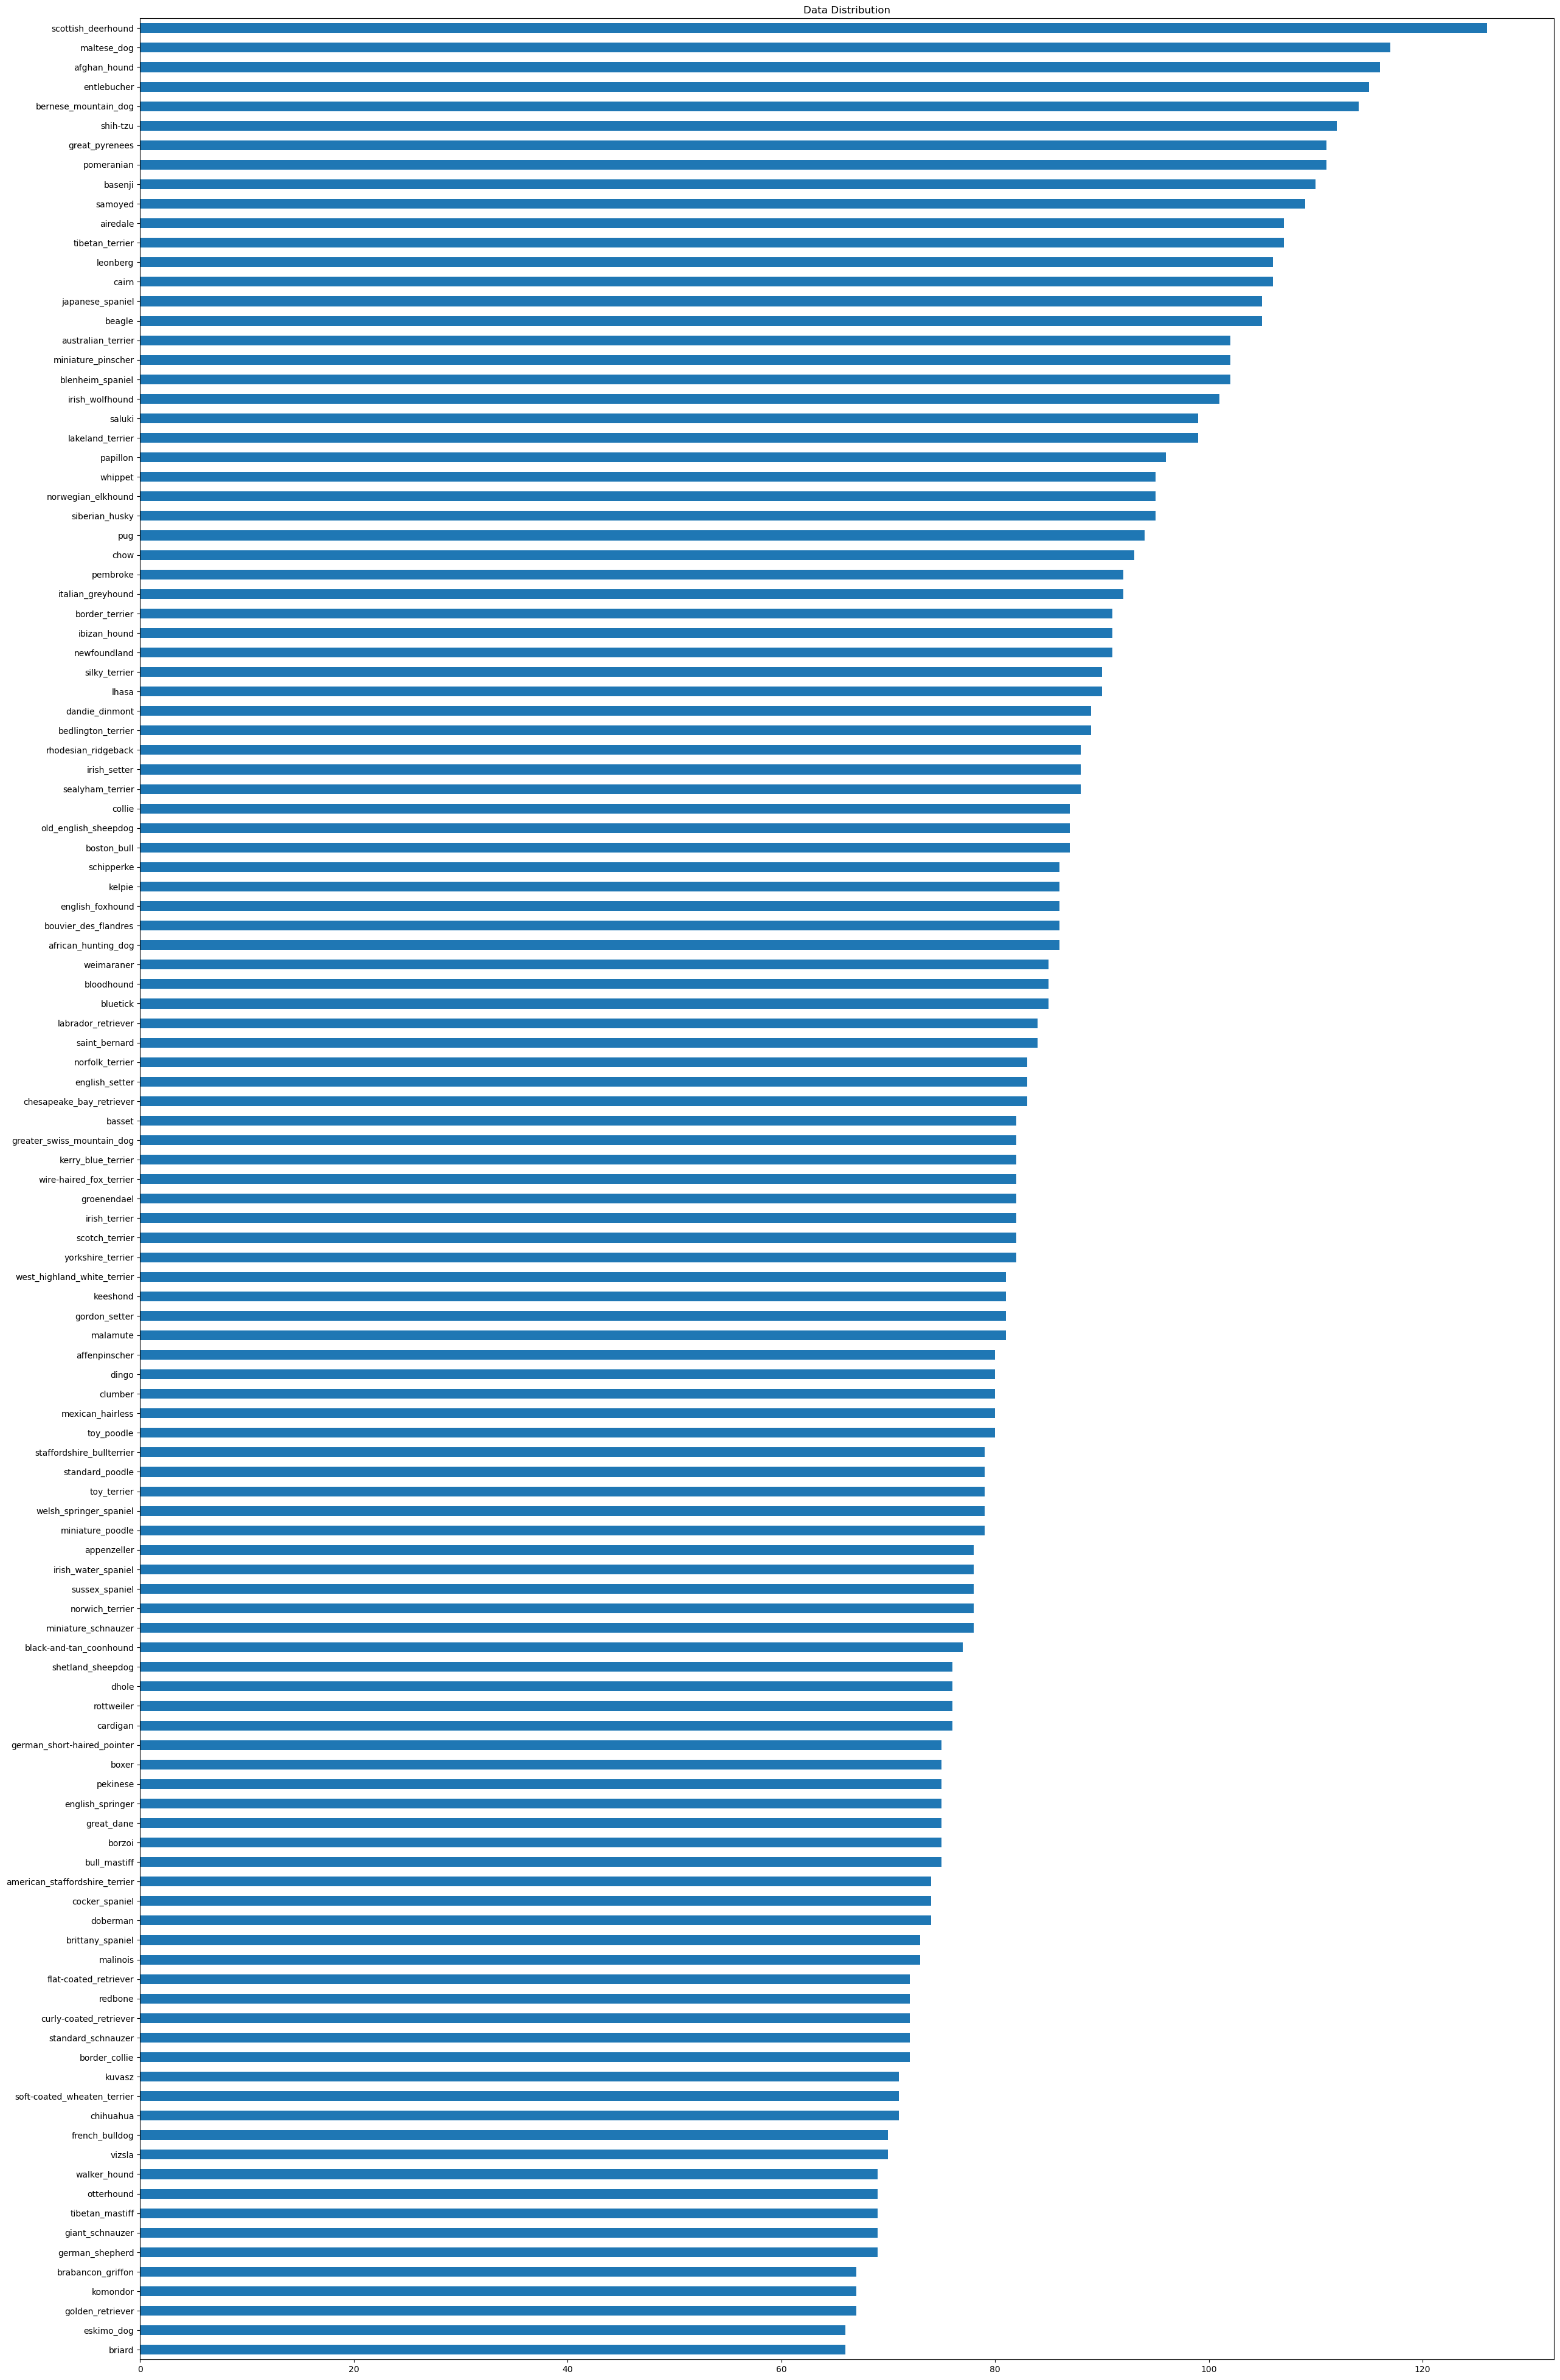

In [ ]:
# General dataset visualisation
df["breed"].value_counts(ascending = True).plot(kind = "barh", fontsize = "10", title = "Data Distribution", figsize = (30,50))
# plt.savefig("ClassDis1.png")

In [ ]:
# Custom class to load the Data
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, images_folder, transform = None):
        self.df = df
        self.images_folder = images_folder
        self.transform = transform

        names= list(set(df['breed']))
        num = [x for x in range(0,len(names))]
        class2id = dict(zip(names,num))
        self.class2index = class2id

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index]["id"]+'.jpg'
        label = self.class2index[self.df.loc[index]["breed"]]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Standard Transformation for the Validation and Test Set
transformation_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
# Loading the Validation and Test set
val_dataset = CustomDataset(val_df, "/kaggle/input/dog-breed-identification/train", transformation_val_test)
test_dataset = CustomDataset(test_df, "/kaggle/input/dog-breed-identification/train", transformation_val_test)

In [ ]:
BATCH_SIZE = 32

val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

# **Training Loop:**

In [ ]:
# Function for training the model on the Training set
def train(epochs, model, train_data, val_data, loss_fn, opt):

    model.train()
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs):

        epoch_run_loss = 0.0
        epoch_run_acc = 0.0
        epoch_run_loss_v = 0.0
        epoch_run_acc_v = 0.0

        for image, label in train_data:

            image = image.cuda()
            label = label.cuda()
            # Prediction of the model given the image
            prediction = model(image)

            # Getting the Loss
            loss = loss_fn(prediction, label)

            # Loss per epoch
            epoch_run_loss = 0.9 * epoch_run_loss + 0.1 * loss.item()

            # Accuracy per epoch
            max_value, max_index = torch.max(prediction, dim = 1)
            epoch_run_acc += (max_index == label).sum()

            # Updating the weights
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Training Loss and Accuracy
        epoch_train_acc = (epoch_run_acc/len(train_data.dataset)).item()
        train_loss.append(epoch_run_loss)
        train_acc.append(epoch_train_acc)

        print("Traning Loss at Epoch {}: {:.4f}".format(epoch, epoch_run_loss))
        print("Traning Accuracy at Epoch {}: {:.4f}".format(epoch, epoch_train_acc))

        # Validation Loss and Accuracy
        model.eval()

        for image, label in val_data:
            image = image.cuda()
            label = label.cuda()
            # Prediction of the model given the image
            prediction = model(image)

            # Getting the Loss
            loss = loss_fn(prediction, label)

            # Loss per epoch
            epoch_run_loss_v = 0.9 * epoch_run_loss_v + 0.1 * loss.item()


            # Accuracy per epoch
            max_value, max_index = torch.max(prediction, dim = 1)
            epoch_run_acc_v += (max_index == label).sum()

        epoch_val_acc = 100 * ((epoch_run_acc_v/len(val_data.dataset)).item())
        val_loss.append(epoch_run_loss_v)
        val_acc.append(epoch_val_acc)

        print("Validation Loss at Epoch {}: {:.4f}".format(epoch, epoch_run_loss_v))
        print("Validation Accuracy at Epoch {}: {:.4f}".format(epoch, epoch_val_acc))

    return train_loss, train_acc, val_loss, val_acc

# **Evaluation Loop:**

In [ ]:
# Function for Evaluating the model
def test(model, test_data, loss_fn):

    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    for image, label in test_data:

        image = image.cuda()
        label = label.cuda()
        # Prediction of the model given the image
        prediction = model(image)

        # Getting the Loss
        loss = loss_fn(prediction, label)

        # Loss per epoch
        test_loss += loss.item()

        # Accuracy per epoch
        max_value, max_index = torch.max(prediction, dim = 1)
        test_acc += (max_index == label).sum()

    test_loss = (test_loss / len(test_data.dataset))
    test_acc = 100 * ((test_acc / len(test_data.dataset)).item())

    return test_loss, test_acc

# **Visualisation function:**

In [ ]:
def plots(train_loss, validation_loss, train_accuracy, validation_accuracy):
    epochs = []

    for i in range(1):
        epochs.append(i)

    # Training and Validation Loss
    plt.plot(epochs, train_loss, label = "Training Loss")
    plt.plot(epochs, validation_loss, label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("Loss.png")
    plt.show()

    for i in range(len(train_accuracy)):
        train_accuracy[i] = train_accuracy[i] * 100

    # Training and Validation Accuracy
    plt.plot(epochs, train_accuracy, label = "Training Accuracy")
    plt.plot(epochs, validation_accuracy, label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("Accuracy.png")
    plt.show()

# **Transfomations and Augmentations:**

In [ ]:
# Loading the Training set with the standard Transforms for Run 1
train_dataset_run1 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_val_test)
train_data_loader_run1 = torch.utils.data.DataLoader(train_dataset_run1, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

In [ ]:
# Transformation and Augmentation for Run 2 - Random Rotation by a degree of 30
transformation_run2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees = 30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Loading the Training set with the standard Transforms and rotation
train_dataset_run2 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_run2)
train_data_loader_run2 = torch.utils.data.DataLoader(train_dataset_run2, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

In [ ]:
# Transformation and Augmentation for Run 3 - Colour Jitter
transformation_run3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Loading the Training set with the standard Transforms and Colour Jitter
train_dataset_run3 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_run3)
train_data_loader_run3 = torch.utils.data.DataLoader(train_dataset_run3, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

In [ ]:
# Transformation and Augmentation for Run 4 - Random Horizontal Flip
transformation_run4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Loading the Training set with the standard Transforms and Horizontal Flip
train_dataset_run4 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_run4)
train_data_loader_run4 = torch.utils.data.DataLoader(train_dataset_run4, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)



In [ ]:
# Transformation and Augmentation for Run 5 - Crop
transformation_run5 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(size = 224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Loading the Training set with the standard Transforms and Crop
train_dataset_run5 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_run5)
train_data_loader_run5 = torch.utils.data.DataLoader(train_dataset_run5, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

In [ ]:
# Transformations and Augmentation for Run 6 - Rotation, Colour Jitter, Horizontal Flip and Crop
transformation_run6 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees = 30),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size = 224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Loading the Training set with all the Transforms
train_dataset_run6 = CustomDataset(train_df, "/kaggle/input/dog-breed-identification/train", transformation_run6)
train_data_loader_run6 = torch.utils.data.DataLoader(train_dataset_run6, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 2)

In [ ]:
# Defining the loss function
loss = nn.CrossEntropyLoss()

# **1. VGG16:**

In [ ]:
# Loading VGG16 with the pre-trained weights
vgg_16 = models.vgg16(pretrained = True)

# Changing the Last Fully Connected layer from 1000 classes to 120 classes
vgg_16.classifier[6].out_features = 120

# We will use the pre-trained weights for the Convolution layers
for param in vgg_16.features.parameters():
    param.requires_grad = False

vgg_16.cuda()

# Defining the loss function
loss = nn.CrossEntropyLoss()

# Defining the optimiser as Stochastic Gradient Descent
optimiser = optim.SGD(vgg_16.classifier.parameters(), lr = 0.0001, momentum = 0.9)

## **1.1. VGG16 - Standard Tranformations:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run1, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

## **1.2. VGG16 - Rotation:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run2, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

## **1.3. VGG16 - Colour Jitter:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run3, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

## **1.4. VGG16 - Horizontal Flip:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run4, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

## **1.5. VGG16 - Crop:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run5, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

## **1.6. VGG16 - Rotation, Colour Jitter, Horizontal Flip, Crop:**

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(10, vgg_16, train_data_loader_run6, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(vgg_16, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)

# **2. Vision Transformer (ViT):**

In [ ]:
def patch_image(images, patch_size):
    # Image shape => (32, 3, 224, 224)
    batch = images.shape[0]
    channel = images.shape[1]
    height = images.shape[2]
    width = images.shape[3]

    # Each patch is of the size 16x16
    patch_height = patch_size[0]
    patch_width = patch_size[1]
    # There are a total of 14x14 = 196 patches per image
    num_patch_h = height // patch_height
    num_patch_w = width // patch_width

    # Each image has 196 images, and the standard tranformer takes an embedding vector of 768
    # This is the flattened output we are trying to get
    # Output shape => (32, 196, 768)
    batch_patch = torch.reshape(images, (batch, channel, num_patch_h, patch_height, num_patch_w, patch_width))
    batch_patch = torch.permute(batch_patch, (0, 1, 2, 4, 3, 5))
    batch_patch = torch.permute(batch_patch, (0, 2, 3, 4, 5, 1))
    batch_patch = torch.reshape(images, (batch, num_patch_h * num_patch_w, channel * patch_height * patch_width))

    return batch_patch

In [ ]:
class ViT(nn.Module):

    def __init__(self, img_size, patch_size, emb_dim, num_heads, dim_feedforward, blocks, num_classes):
        super(ViT, self).__init__()

        # img_size = image size with (channels, height, width)
        # patch_size = Dimensions of each patch in an image
        # emd_dim = Linear tranformation value
        # num_heads = number of heads for the multi head attention models
        # dim_feedforward = Dimensions of the feed forward network (2048 is default - pytorch)
        self.img_size = img_size
        self.patch_size = patch_size
        n_p = (img_size[1] // patch_size[0]) * (img_size[2] // patch_size[1])

        token_size = patch_size[0] * patch_size[1] * img_size[0]
        self.linear = nn.Linear(token_size, emb_dim)

        # Classification token with the shape => (1, 1, 196)
        self.c_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Positional Emdedding
        self.pos_emb = nn.Parameter(torch.randn(n_p, emb_dim))

        # Transfomer model in pytorch
        encoder_layer = nn.TransformerEncoderLayer(emb_dim, num_heads, dim_feedforward, activation = "gelu", batch_first = True)
        self.transformer = nn.TransformerEncoder(encoder_layer, blocks)

        self.mlp = nn.Sequential(nn.Linear(emb_dim, num_classes), nn.Softmax(dim = -1))

    def forward(self, images):

        batch = images.shape[0]
        channel = images.shape[1]
        height = images.shape[2]
        width = images.shape[3]

        # patch shape => (32, 196, 768)
        patches = patch_image(images, self.patch_size)

        # Linear Layer, shape => (32, 196, 196)
        tokens = self.linear(patches)

        # Adding the Classification token
        # Shape => (32, 1, 196)
        c_token = self.c_token.expand([batch, -1, -1])

        # Positional Embedding shape => (32, 196, 196)
        embedding = tokens + self.pos_emb

        # Concatenate the classification token with other embedding
        # Shape => (32, 197, 196)
        embedding = torch.cat([c_token, tokens], axis = 1)

        # Passing the embedding to the Transformer
        # transformer gives the same shape as the input
        # shape => (32, 197, 196)
        transformer = self.transformer(embedding)

        # Classification head which outputs the probability of each class
        # This is only done with the classification token at the top of the embedding
        # classification_token, shape => (32, 1, 196)
        classification_token = transformer[:,0,:]

        # Shape => (32, 120)
        classification = self.mlp(classification_token)
        result = torch.argmax(classification, dim = 1)

        return classification

In [ ]:
model = ViT(
    img_size=(3, 224, 224),
    patch_size = (16, 16),
    emb_dim = 196,
    num_heads = 4,
    dim_feedforward = 2048,
    blocks = 8,
    num_classes = 120
  )
model.cuda()

In [ ]:
# Training the model
train_loss, train_accuracy, validation_loss, validation_accuracy = train(2, model, train_data_loader_run4, val_data_loader, loss, optimiser)

# Visualisation
plots(train_loss, validation_loss, train_accuracy, validation_accuracy)

# Accuracy and Loss on the Test set
test_loss, test_accuracy = test(model, test_data_loader, loss)
print("Test Loss = ", test_loss)
print("Test Accuracy = ", test_accuracy)